#Code to mask cropped land
This code utilises the powerful Google Earth Engine to mask the cropped land using mean NDVI during the main crop growing stages. A value of the mean NDVI >0.3 becomes crop land, whereas below it is classified as fallow.

In [1]:
pip install rasterio  --quiet
pip install xarray-spatial   --quiet
pip install geemap   --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 14.1 MB/s eta 0:00:00


In [4]:
import rasterio
import geopandas as gpd
import ee
import numpy as np
from rasterio import windows, warp, features
from rasterio.mask import geometry_mask
from PIL import Image
import xarray as xr
import geemap

In [5]:
# Authenticate to Earth Engine
ee.Authenticate()

In [7]:
ee.Initialize(project='ee-mmul')      # replace this with name of your project id in GEE (if you dont have one then 'register a new cloud project')
print("Earth Engine API initialized successfully.")

Earth Engine API initialized successfully.


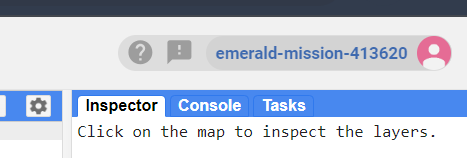

## Upload shapefile

In [8]:
#To upload file.
from google.colab import files
uploaded = files.upload()

## Define period
Select a period that defines the main growing season

In [9]:
# Specify the season of interest
start_date = '2022-12-01'
end_date = '2023-03-31'

# Read your GeoDataFrame from a shapefile
gdf = gpd.read_file("/content/Wad_Helal.shp")

## Define functions

In [10]:
# Function to format a Shapely geometry to a GeoJSON-like dictionary
def format_geometry(geometry):
    if geometry.geom_type == 'Polygon':
        coordinates = [list(coord) for coord in geometry.exterior.coords]
        return {
            "type": "Polygon",
            "coordinates": [coordinates]
        }
    else:
        return None

# Apply the formatting function to the 'geometry' column
gdf['formatted_geometry'] = gdf['geometry'].apply(format_geometry)

# Remove rows with NaN formatted geometries
gdf = gdf.dropna(subset=['formatted_geometry'])

# Convert the column to a list of dictionaries
formatted_geometry_list = gdf['formatted_geometry'].tolist()

# Assuming the first geometry in the list is the area of interest
area_of_interest = ee.Geometry(formatted_geometry_list[0])

# Function to mask clouds using the Sentinel-2 'SCL' band.
def mask_clouds(image):
    cloud_mask = image.select('SCL').lt(8)
    return image.updateMask(cloud_mask)

# Function to calculate NDVI
def calculate_ndvi(image):
    masked_image = mask_clouds(image)
    return masked_image.normalizedDifference(['B8', 'B4']).rename('NDVI').copyProperties(image, ['system:time_start'])

# Function to calculate the average NDVI over the study area
def calculate_average_ndvi(start_date, end_date, area_of_interest):
    # Convert to EE Date objects
    ee_start_date = ee.Date(start_date)
    ee_end_date = ee.Date(end_date)

    # Filter the collection for the date range and area of interest
    collection = (ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")
                  .filterBounds(area_of_interest)
                  .filterDate(ee_start_date, ee_end_date)
                  .filterMetadata('CLOUDY_PIXEL_PERCENTAGE', 'less_than', 70))

    # Map the function to calculate NDVI for each image in the collection
    ndvi_collection = collection.map(calculate_ndvi)

    # Calculate the mean NDVI over the date range
    mean_ndvi = ndvi_collection.mean().clip(area_of_interest)

    return mean_ndvi

# Function to create the irrigation mask
def create_irrigation_mask(mean_ndvi):
    irrig_mask = mean_ndvi.gt(0.3)
    return irrig_mask

##Create irrigation mask and save on google drive

In [11]:
# Calculate the average NDVI
mean_ndvi = calculate_average_ndvi(start_date, end_date, area_of_interest)

# Create the irrigation mask
irrigation_mask = create_irrigation_mask(mean_ndvi)

# Only keep pixels where the irrigation mask is 1 and mask out all other pixels
irrigation_mask = irrigation_mask.updateMask(irrigation_mask)

# Export the irrigation mask image to Google Drive
task = ee.batch.Export.image.toDrive(
    image=irrigation_mask,
    description='Wad_Helal_11_Irrigation_Mask',
    folder="Irrigation_Mask_Folder",
    fileNamePrefix='Wad_Helal_11_Irrigation_Mask',
    region=area_of_interest.bounds().getInfo()['coordinates'],
    scale=10,
    fileFormat='GeoTIFF',
    maxPixels=500000000
)
task.start()

# Print the irrigation mask
#print(irrigation_mask.getInfo())